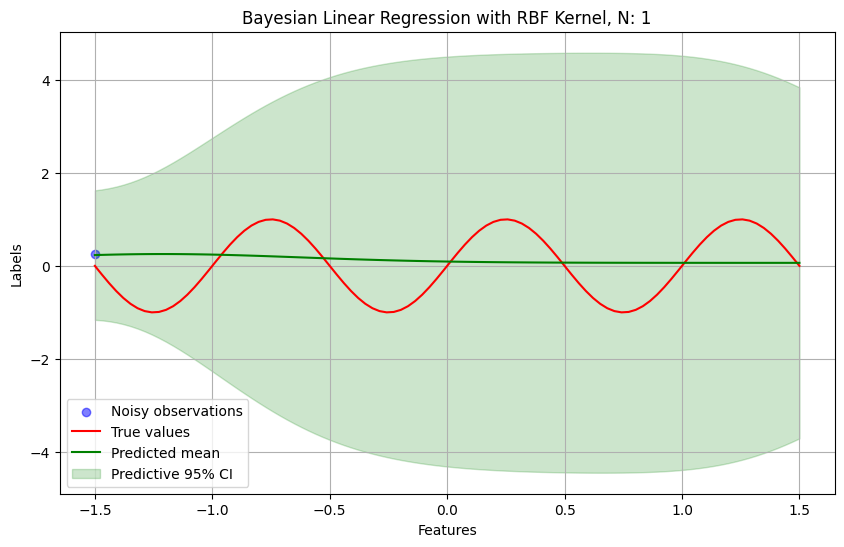

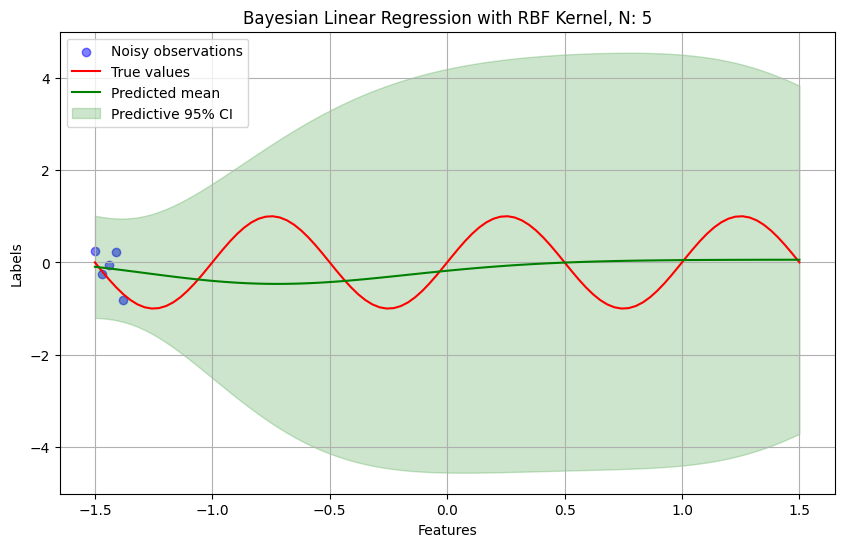

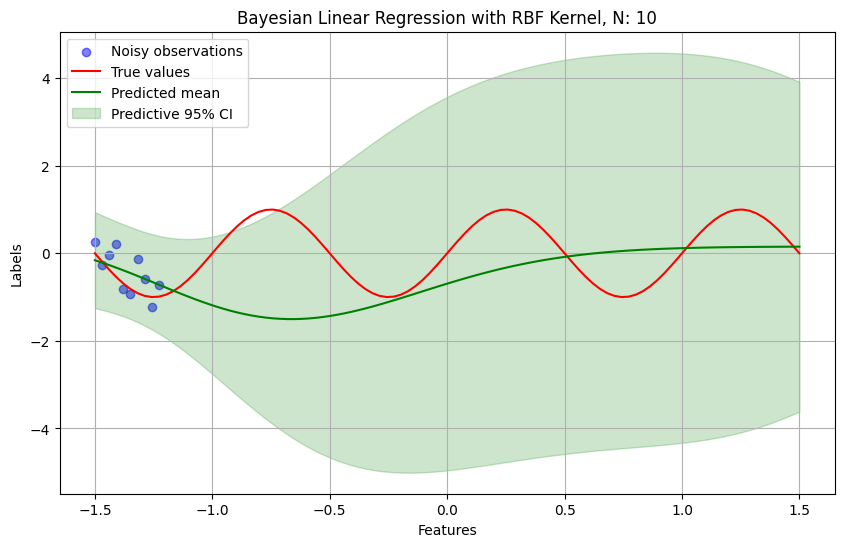

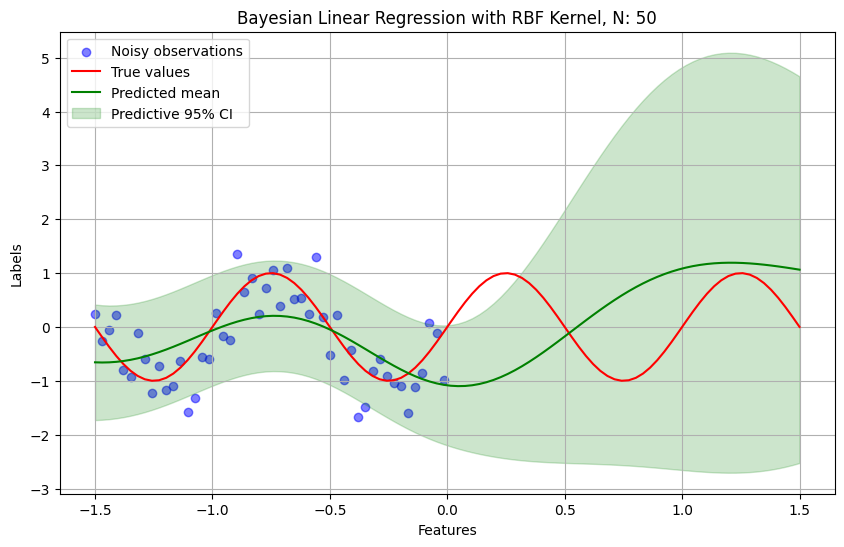

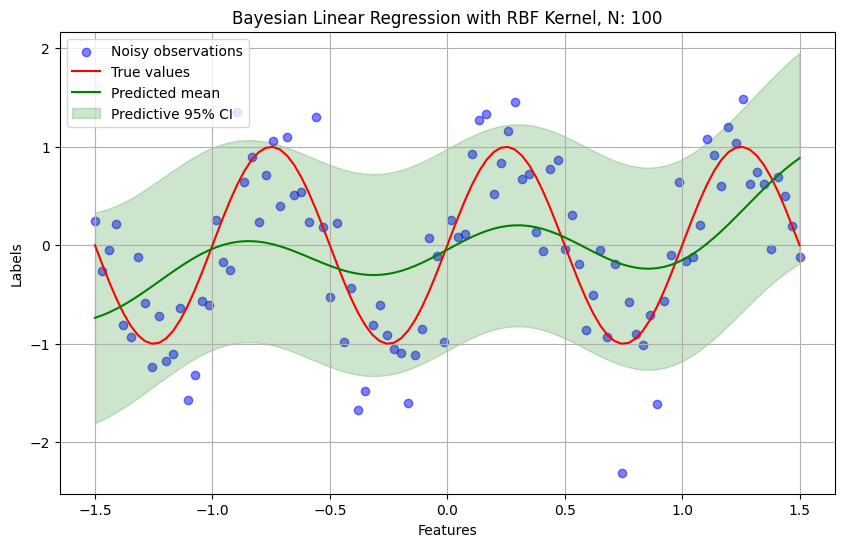

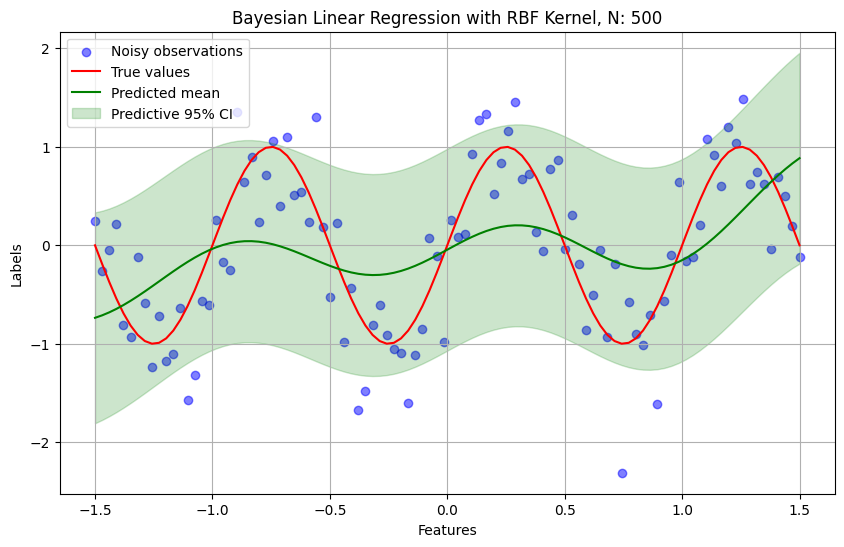

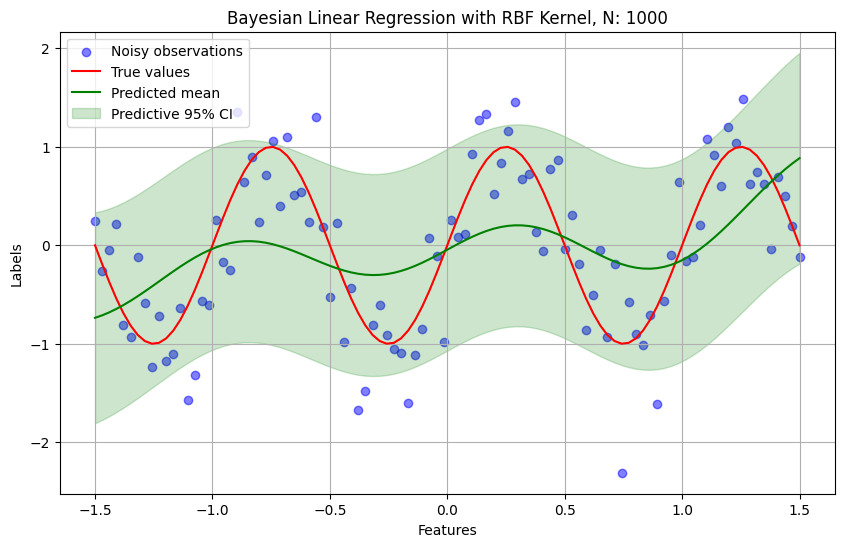

In [2]:
from scipy.stats import multivariate_normal
from scipy.stats import norm as univariate_normal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class BayesianLinearRegressionRBF:
    def __init__(self, prior_mean: np.ndarray, prior_cov: np.ndarray, noise_var: float, rbf_centers: np.ndarray, rbf_length_scale: float):
        self.prior_mean = prior_mean
        self.prior_cov = prior_cov
        self.noise_var = noise_var
        self.rbf_centers = rbf_centers
        self.rbf_length_scale = rbf_length_scale

        self.post_mean = prior_mean
        self.post_cov = prior_cov
        self.param_posterior = multivariate_normal(mean=self.post_mean, cov=self.post_cov)

    def compute_design_matrix(self, features: np.ndarray) -> np.ndarray:
        features = features.reshape(-1, 1)  # Ensure 2D column vector
        rbf_features = np.exp(-0.5 * ((features - self.rbf_centers) / self.rbf_length_scale) ** 2)
        design_matrix = np.hstack([np.ones((features.shape[0], 1)), rbf_features])
        return design_matrix

    def update_posterior(self, features: np.ndarray, targets: np.ndarray):
        design_matrix = self.compute_design_matrix(features)

        S_N_inv = np.linalg.inv(self.prior_cov) + (1 / self.noise_var) * design_matrix.T @ design_matrix
        self.post_cov = np.linalg.inv(S_N_inv)
        self.post_mean = self.post_cov @ (
            np.linalg.inv(self.prior_cov) @ self.prior_mean +
            (1 / self.noise_var) * design_matrix.T @ targets
        )
        self.param_posterior = multivariate_normal(mean=self.post_mean, cov=self.post_cov)

    def predict(self, features: np.ndarray):
        design_matrix = self.compute_design_matrix(features)
        pred_mean = design_matrix @ self.post_mean
        pred_cov = design_matrix @ self.post_cov @ design_matrix.T + self.noise_var * np.eye(len(features))
        pred_posterior = univariate_normal(loc=pred_mean, scale=np.sqrt(np.diag(pred_cov)))
        return pred_posterior

    @staticmethod
    def visualize(X, y, X_sampled, y_noisy, X_test, pred_posterior, n):
        plt.figure(figsize=(10, 6))
        plt.scatter(X_sampled, y_noisy, label="Noisy observations", color='blue', alpha=0.5)
        plt.plot(X, y, color='red', label="True values")
        plt.plot(X_test, pred_posterior.mean(), label="Predicted mean", color='green')
        plt.fill_between(X_test,
                         pred_posterior.mean() - 2 * pred_posterior.std(),
                         pred_posterior.mean() + 2 * pred_posterior.std(),
                         color='green', alpha=0.2, label="Predictive 95% CI")
        plt.xlabel("Features")
        plt.ylabel("Labels")
        plt.title(f"Bayesian Linear Regression with RBF Kernel, N: {n}")
        plt.legend()
        plt.grid(True)
        plt.show()

# -------------------------
# Setup and Experiment Code
# -------------------------

np.random.seed(42)

# Generate data
X = np.linspace(-1.5, 1.5, 100)
y = np.sin(2 * np.pi * X)
noise_std = 0.5
y_noisy = y + np.random.normal(0, noise_std, size=y.shape)

# RBF kernel parameters
rbf_centers = np.linspace(-1.5, 1.5, 15)
rbf_length_scale = 0.5

# Prior settings
prior_mean = np.zeros(len(rbf_centers) + 1)
prior_cov = np.eye(len(rbf_centers) + 1) * 1.0
noise_var = noise_std ** 2

# Evaluate over different training sizes
n_train_samples = [1, 5, 10, 50, 100, 500, 1000]
final_result = {'X': [], 'y': [], 'y_stddev': []}

for n in n_train_samples:
    model = BayesianLinearRegressionRBF(prior_mean, prior_cov, noise_var, rbf_centers, rbf_length_scale)
    X_test = np.linspace(-1.5, 1.5, 100)
    X_sampled = X[:n]
    y_sampled = y[:n]
    y_noisy_sampled = y_noisy[:n]

    model.update_posterior(X_sampled, y_noisy_sampled)
    pred_posterior = model.predict(X_test)

    if n == 1000:
        final_result['X'] = X_test
        final_result['y'] = pred_posterior.mean()
        final_result['y_stddev'] = pred_posterior.std()
        pd.DataFrame(final_result).to_csv('output.csv', index=False)

    model.visualize(X, y, X_sampled, y_noisy_sampled, X_test, pred_posterior, n)